In [13]:
import os
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


In [175]:
bevölkerung = pd.read_excel(f"Data\\12411-0012_complete.xlsx", index_col=0)

#read sterbefälle pro monat
sterbefälle_monat = pd.read_excel(f"Data\\sonderauswertung-sterbefaelle_groß.xlsx", sheet_name='D_2016-2022_Monate_AG_Ins') #Datensatz ist selbst zusammengebaut
sterbefälle_monat = sterbefälle_monat[sterbefälle_monat.columns].replace(["-",".","X "],0)
sterbefälle_monat

,Nr.,Jahr,Alter,Januar,Februar,März,April,Mai,Juni,Juli,August,September,Oktober,November,Dezember,Insgesamt
0,35,2020,Insgesamt,84980,80030,87396,83830,75835,72159,73795,78742,74243,79781,85989,108792,985572
1,36,2020,0-15,272,291,313,289,277,275,278,273,277,260,240,261,3306
2,37,2020,15-30,329,330,320,288,311,329,335,357,305,320,309,311,3844
3,38,2020,30-35,248,191,229,221,199,213,249,204,224,206,197,226,2607
4,39,2020,35-40,374,330,332,345,346,308,336,316,318,326,328,402,4061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,387,2000,75-80,12695,11668,10979,10282,10020,9795,9784,9956,9537,10346,10313,10911,126286
353,388,2000,80-85,10350,9692,8954,8351,8124,7919,8018,7948,7977,8702,8806,9370,104211
354,389,2000,85-90,15951,14812,13574,12355,11838,11343,11402,11365,11133,11863,12123,12829,150588
355,390,2000,90-95,9386,8742,7715,7130,6838,6863,6655,6894,6652,7409,7617,8126,90027


In [176]:
#Sterbefälle einteilen
#bildet summe aus gruppe 90-95 und gruppe ü 95, ersetzt die 90-95 row damit, benennt sie um und dropt die ü95 reihe.
new_row = (sterbefälle_monat.loc[sterbefälle_monat["Alter"]=="90-95"]) + (sterbefälle_monat.loc[sterbefälle_monat["Alter"]=="95 u. mehr"])
age_90_95 = sterbefälle_monat.loc[sterbefälle_monat["Alter"]=="90-95"]
mehr_95 = sterbefälle_monat.loc[sterbefälle_monat["Alter"]=="95 u. mehr"]

new_row = age_90_95.iloc[0,3:] + mehr_95.iloc[0,3:]
index_95 = list(age_90_95.index)
index_mehr = list(mehr_95.index)

for i in range (len(index_95)):
    new_row = age_90_95.iloc[i,3:] +mehr_95.iloc[i,3:]
    sterbefälle_monat.loc[index_95[i], "Januar":] = new_row
    sterbefälle_monat.drop(index_mehr[i], inplace=True)


sterbefälle_monat['Alter'].replace({'90-95': '90<'}, inplace = True)
sterbefälle_monat = sterbefälle_monat.rename(columns={'Januar': 1,'Februar': 2,'März': 3,'April': 4,'Mai': 5,'Juni': 6,'Juli': 7,'August': 8,'September': 9,'Oktober': 10,'November': 11,'Dezember': 12})


In [177]:
print(sterbefälle_monat.loc[sterbefälle_monat["Jahr"]==2020])
#print(sterbefälle_monat)

    Nr.  Jahr      Alter      1      2      3      4      5      6      7  \
0    35  2020  Insgesamt  84980  80030  87396  83830  75835  72159  73795   
1    36  2020       0-15    272    291    313    289    277    275    278   
2    37  2020      15-30    329    330    320    288    311    329    335   
3    38  2020      30-35    248    191    229    221    199    213    249   
4    39  2020      35-40    374    330    332    345    346    308    336   
5    40  2020      40-45    486    458    508    504    497    469    458   
6    41  2020      45-50    856    803    855    859    803    798    791   
7    42  2020      50-55   1943   1697   1878   1714   1737   1645   1710   
8    43  2020      55-60   3159   3002   3158   3029   3005   2902   2937   
9    44  2020      60-65   4414   4166   4454   4213   4150   3914   4107   
10   45  2020      65-70   5820   5520   6089   5638   5382   5155   5271   
11   46  2020      70-75   6653   6224   6893   6603   6134   5905   5895   

In [178]:
#alle Altersgruppen einteilen
rows = []
x = 0
j = 0
for k in range (1 ,32): 
    x=0
    for i in range(0, 92):
        k2 = k*91
        if i == 0 and k == 1:
            bevölkerungs_anzahl = bevölkerung.loc[bevölkerung.index[0]]["Gesamt"] #Gesamtbevölkerung je altersgruppe
        if i == 0 and k != 1:
            bevölkerungs_anzahl = bevölkerung.loc[bevölkerung.index[i+(k-1)*92]]["Gesamt"]
        else:
            bevölkerungs_anzahl = bevölkerung.loc[bevölkerung.index[i+((k-1)*92)]]["Gesamt"]

        if ( i < 15):
            x += bevölkerungs_anzahl
            if (i == 14):
                rows.append([1990+k-1,"0 - "+"<{}".format(i+1), x])
                x = 0   

        elif (i >= 15 and  i < 30):
    
            x += bevölkerungs_anzahl
            if i == 29:
                rows.append([1990+k-1,(str(i-14)+" - <"+str(i+1)), x])

            
                x = 0

        elif (i >= 30 and  i < 90):
            j += 1
            x += bevölkerungs_anzahl
            if j == 5:
                rows.append([1990+k-1,(str(i-4)+" - <"+str(i+1)), x])
                j = 0
                x = 0

        elif i == 90:
            x += bevölkerungs_anzahl
            rows.append([1990+k-1,"90=<", x])
            x = 0

        elif i == 91:
            x += bevölkerungs_anzahl
            rows.append([1990+k-1,"Gesamt", x])
            x=0
       
        

new_df = pd.DataFrame(rows, columns=["Jahr","Alter", "Anzahl"])

In [179]:
standard_bevölkerung = new_df.loc[new_df["Jahr"]==2020]
standard_bevölkerung

,Jahr,Alter,Anzahl
480,2020,0 - <15,11477800
481,2020,15 - <30,13340204
482,2020,30 - <35,5581088
483,2020,35 - <40,5290876
484,2020,40 - <45,5034888
485,2020,45 - <50,5035860
486,2020,50 - <55,6487224
487,2020,55 - <60,6817318
488,2020,60 - <65,5818137
489,2020,65 - <70,4899104


In [180]:
#rohe sterberate
#loop über jahre
sterberaten_roh = []
for n in range(0,21):
    z = sterbefälle_monat.loc[(sterbefälle_monat["Jahr"]==2020-n)]
    sterberate_gesamt = 0

    gesamt_bev = standard_bevölkerung.loc[standard_bevölkerung.index[15]][2]
    
    #loop über altersgruppen
    for i in range(1,16):
        mri = ((z.loc[z.index[i]]["Insgesamt"]) / gesamt_bev) * 100000  #sterberate je altersgruppe
        sterberate_gesamt += mri 

    

    #print(2020-n, "Roh:", sterberate_jahr)
    sterberaten_roh.append([2020-n, round(sterberate_gesamt,2 )])
    sterberate_gesamt = 0

sterberaten_roh

[[2020, 1185.22],
 [2019, 1129.84],
 [2018, 1148.31],
 [2017, 1121.11],
 [2016, 1095.42],
 [2015, 1112.62],
 [2014, 1044.26],
 [2013, 1074.89],
 [2012, 1045.74],
 [2011, 1024.99],
 [2010, 1032.73],
 [2009, 1027.65],
 [2008, 1015.5],
 [2007, 994.71],
 [2006, 988.07],
 [2005, 998.41],
 [2004, 984.03],
 [2003, 1026.93],
 [2002, 1012.19],
 [2001, 996.38],
 [2000, 1008.71]]

In [182]:
#altersbereinigt
sterberaten_bereinigt = []
#loop über jahre
for n in range(0,21):
    z = sterbefälle_monat.loc[(sterbefälle_monat["Jahr"]==2020-n)]
    q = new_df.loc[new_df["Jahr"]==2020-n]
    erg_sum = 0
    gesamt_bev = standard_bevölkerung.loc[standard_bevölkerung.index[15]][2]

    #loop über wochen

    sum = 0
    #loop über Altersgruppen
    for i in range(1,16):

        asx = standard_bevölkerung.loc[standard_bevölkerung.index[i]][2] #bevölkerung je altersgruppe Standardbevölkerung
        bevölkerung_grp = q.loc[q.index[i]][2] #größe Bevölkerungsruppe untersuchte Bevölkerung
        subx = ((z.loc[z.index[i]]["Insgesamt"]) / bevölkerung_grp) * 100000 #sterberate je altersgruppe
        
        sum += (asx * subx)    
        

    erg = sum / gesamt_bev
    erg_sum += erg

    #print(2020-n, "Altersbereinigt:",erg_sum)
    sterberaten_bereinigt.append([2020-n, erg_sum])

sterberaten_bereinigt

[[2020, 1185.2223348939644],
 [2019, 1153.487629343934],
 [2018, 1201.993299315672],
 [2017, 1192.8410051402022],
 [2016, 1185.3427249856886],
 [2015, 1228.7261311632426],
 [2014, 1181.278062614641],
 [2013, 1247.7715959394989],
 [2012, 1233.590972872587],
 [2011, 1236.4141345853484],
 [2010, 1237.3042842079394],
 [2009, 1278.8992469205773],
 [2008, 1288.9821099823923],
 [2007, 1264.5246964293092],
 [2006, 1270.1336245930704],
 [2005, 1317.0019118498801],
 [2004, 1352.5543556248485],
 [2003, 1431.6752214355818],
 [2002, 1393.5297427966325],
 [2001, 1382.556033779675],
 [2000, 1445.0263790648735]]

In [183]:
sterberaten_roh = pd.DataFrame(sterberaten_roh, columns=["Jahr", "Sterberate"])
sterberaten_bereinigt = pd.DataFrame(sterberaten_bereinigt, columns=["Jahr", "Sterberate"])

(array([1997.5, 2000. , 2002.5, 2005. , 2007.5, 2010. , 2012.5, 2015. ,
        2017.5, 2020. , 2022.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

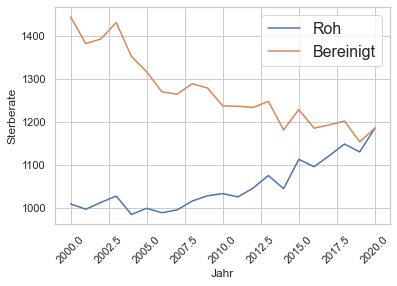

In [184]:

ax = sns.lineplot(x="Jahr",  y='Sterberate', data=sterberaten_roh)
sns.lineplot(ax=ax, x="Jahr",  y='Sterberate', data=sterberaten_bereinigt)
plt.legend(labels=['Roh','Bereinigt'],fontsize= 16)
sns.set_theme(style="whitegrid")
plt.xticks(rotation=45)